In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000110_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000150_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000100_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000120_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000090_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000168_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000136_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000088_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000028_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000035_000019_leftImg8bit.png
/kaggle/input/cityscapes/Cityspaces/images/val/munster/munster_000023_

In [25]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [26]:

IMG_DIR = "/kaggle/input/cityscapes/Cityspaces/images/train"
GT_DIR  = "/kaggle/input/cityscapes/Cityspaces/gtFine/train"

data = []
for city in os.listdir(IMG_DIR):
    city_img_path = os.path.join(IMG_DIR, city)
    city_gt_path  = os.path.join(GT_DIR, city)
    if os.path.isdir(city_img_path):
        for file in os.listdir(city_img_path):
            if file.endswith("_leftImg8bit.png"):
                img_path = os.path.join(city_img_path, file)
                label_file = file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(city_gt_path, label_file)
                if os.path.exists(label_path):
                    data.append({"image_path": img_path, "label_path": label_path, "city": city})

df = pd.DataFrame(data)
print("Total image-label pairs:", len(df))

Total image-label pairs: 2975


In [27]:

train_root = "/kaggle/input/cityscapes/Cityspaces/images/train"

total_images = 0

for city in os.listdir(train_root):
    city_path = os.path.join(train_root, city)
    if os.path.isdir(city_path):
        num_images = len([f for f in os.listdir(city_path) if f.endswith(('.png', '.jpg'))])
        print(f"{city}: {num_images} images")
        total_images += num_images


dusseldorf: 221 images
darmstadt: 85 images
tubingen: 144 images
erfurt: 109 images
bochum: 96 images
krefeld: 99 images
weimar: 142 images
bremen: 316 images
aachen: 174 images
hamburg: 248 images
monchengladbach: 94 images
hanover: 196 images
zurich: 122 images
jena: 119 images
stuttgart: 196 images
strasbourg: 365 images
cologne: 154 images
ulm: 95 images


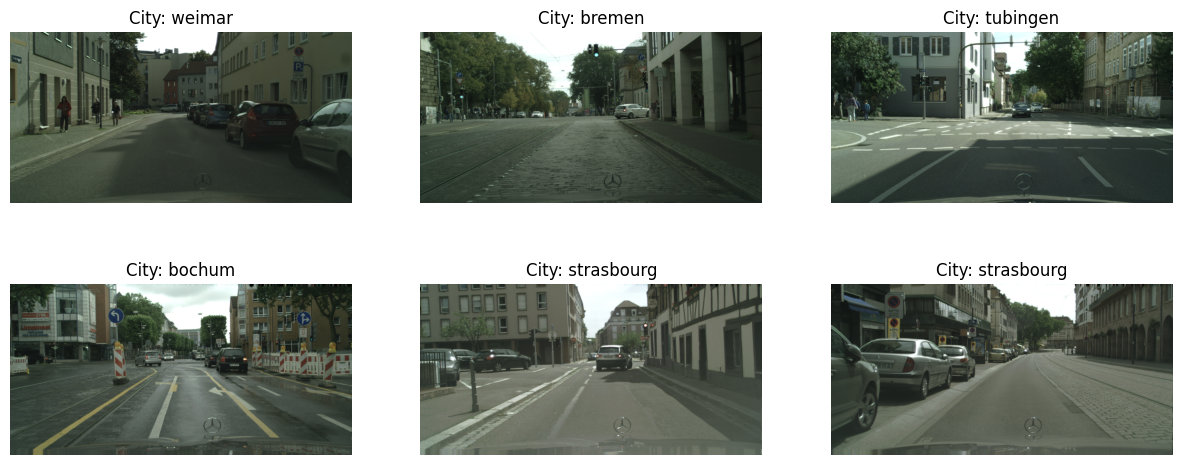

In [28]:
def show_samples(dataframe, n=6):
    samples = dataframe.sample(min(n, len(dataframe)))
    plt.figure(figsize=(15,6))
    for i, row in enumerate(samples.itertuples()):
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.title(f"City: {row.city}")
        plt.axis("off")
    plt.show()

show_samples(df)


In [29]:
data = []
for city in os.listdir(IMG_DIR):
    city_img_path = os.path.join(IMG_DIR, city)
    city_gt_path  = os.path.join(GT_DIR, city)
    if os.path.isdir(city_img_path):
        for file in os.listdir(city_img_path):
            if file.endswith("_leftImg8bit.png"):
                img_path = os.path.join(city_img_path, file)
                label_file = file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(city_gt_path, label_file)
                if os.path.exists(label_path):
                    data.append({"image_path": img_path, "label_path": label_path, "city": city})

df = pd.DataFrame(data)
print("Total image-label pairs:", len(df))
df.head()


Total image-label pairs: 2975


,image_path,label_path,city
0,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,dusseldorf
1,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,dusseldorf
2,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,dusseldorf
3,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,dusseldorf
4,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,dusseldorf


Analyzing Pixels: 100%|██████████| 2975/2975 [00:59<00:00, 50.28it/s]


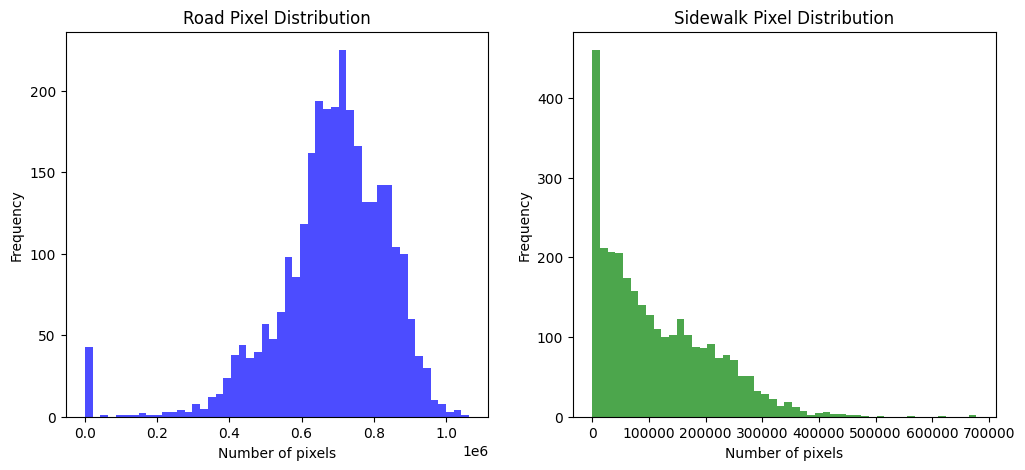

,road_pixels,sidewalk_pixels
count,2.975000e+03,2975.000000
mean,6.845098e+05,112971.695126
std,1.596952e+05,98052.080686
min,0.000000e+00,0.000000
25%,6.154225e+05,31363.000000
50%,7.018210e+05,87859.000000
75%,7.920230e+05,177133.500000
max,1.063767e+06,677677.000000


In [30]:

# تعريف IDs للـ Road و Sidewalk
ROAD_LABEL_ID = 7
SIDEWALK_LABEL_ID = 8

# تخزين عدد البيكسلات لكل صورة
road_pixel_counts = []
sidewalk_pixel_counts = []

# Loop على كل الصور في الـ DataFrame
for row in tqdm(df.itertuples(), total=len(df), desc="Analyzing Pixels"):
    label = cv2.imread(row.label_path, cv2.IMREAD_GRAYSCALE)
    road_pixel_counts.append(np.sum(label == ROAD_LABEL_ID))
    sidewalk_pixel_counts.append(np.sum(label == SIDEWALK_LABEL_ID))

# إنشاء DataFrame جديد للاحصائيات
pixel_analysis_df = pd.DataFrame({
    "road_pixels": road_pixel_counts,
    "sidewalk_pixels": sidewalk_pixel_counts,
    "city": [row.city for row in df.itertuples()]
})

# عرض الهيستوجرام
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(pixel_analysis_df["road_pixels"], bins=50, color='blue', alpha=0.7)
plt.title("Road Pixel Distribution")
plt.xlabel("Number of pixels")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(pixel_analysis_df["sidewalk_pixels"], bins=50, color='green', alpha=0.7)
plt.title("Sidewalk Pixel Distribution")
plt.xlabel("Number of pixels")
plt.ylabel("Frequency")
plt.show()

# عرض ملخص إحصائي
pixel_analysis_df.describe()


In [31]:


IMG_WIDTH = 512
IMG_HEIGHT = 256

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [32]:

class CityscapesAugmentedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # قراءة الصورة والماسكات
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row['label_path'], cv2.IMREAD_UNCHANGED)

        # تطبيق التحويلات
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        mask_tensor = torch.from_numpy(mask).long()
        return img, mask_tensor


In [33]:

from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = CityscapesAugmentedDataset(train_df, transform=train_transform)
val_dataset   = CityscapesAugmentedDataset(val_df, transform=val_transform)
test_dataset  = CityscapesAugmentedDataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")
print(f"Total train images: {len(train_dataset)} (Model will see them in different way)")


Train batches: 298, Val batches: 38, Test batches: 38
Total train images: 2380 (Model will see them in different way)


In [34]:
from torch.utils.data import Dataset, DataLoader

def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    return img, mask

class CityscapesPanopticDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img, mask = preprocess_image_mask(row['image_path'], row['label_path'])
        
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        
        mask_tensor = torch.from_numpy(mask).long()
        return img, mask_tensor


In [35]:

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = CityscapesPanopticDataset(train_df)
val_dataset   = CityscapesPanopticDataset(val_df)
test_dataset  = CityscapesPanopticDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")



Train batches: 298, Val batches: 38, Test batches: 38


In [19]:
# ============================================================
# 0️⃣ Setup
# ============================================================
import os, random, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import swin_t, Swin_T_Weights
from PIL import Image
import numpy as np

# ============================================================
# 3️⃣ Dataset
# ============================================================
class PanopticDataset(Dataset):
    def __init__(self, root, split="train", fraction=0.25):
        self.imgs, self.sems = [], []
        img_root = os.path.join(root, "images", split)
        lbl_root = os.path.join(root, "gtFine", split)
        for city in sorted(os.listdir(img_root)):
            city_img_path = os.path.join(img_root, city)
            city_lbl_path = os.path.join(lbl_root, city)
            for f in os.listdir(city_img_path):
                if f.endswith("_leftImg8bit.png"):
                    base = f.replace("_leftImg8bit.png","")
                    self.imgs.append(os.path.join(city_img_path, f))
                    self.sems.append(os.path.join(city_lbl_path, base+"_gtFine_labelIds.png"))
        n = int(len(self.imgs)*fraction)
        self.imgs, self.sems = self.imgs[:n], self.sems[:n]
        self.train = split=="train"

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, i):
        img = torch.from_numpy(np.array(Image.open(self.imgs[i]).convert("RGB"))).permute(2,0,1).float()/255.0
        sem = torch.from_numpy(np.array(Image.open(self.sems[i]))).long()
        sem[sem>18]=255
        return preprocess(img, sem, self.train)

# ============================================================
# 4️⃣ Attention Modules
# ============================================================
class SpatialAttentionModule(nn.Module): 
    def __init__(self, kernel_size=7): 
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        return x * torch.sigmoid(self.conv(y))

class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        hidden = max(1, in_channels // reduction)
        self.fc1 = nn.Linear(in_channels, hidden)
        self.fc2 = nn.Linear(hidden, in_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        out = torch.sigmoid(
            self.fc2(self.relu(self.fc1(avg_pool))) + self.fc2(self.relu(self.fc1(max_pool)))
        ).view(b, c, 1, 1)
        return x * out.expand_as(x)

# ============================================================
# 5️⃣ ASPP
# ============================================================
class ASPP(nn.Module):
    def __init__(self, in_c, out_c=256):
        super().__init__()
        self.blocks = nn.ModuleList([
            nn.Conv2d(in_c,out_c,1),
            nn.Conv2d(in_c,out_c,3,padding=6,dilation=6),
            nn.Conv2d(in_c,out_c,3,padding=12,dilation=12),
            nn.Conv2d(in_c,out_c,3,padding=18,dilation=18)
        ])
        self.proj = nn.Conv2d(out_c*4,out_c,1)
    def forward(self,x): 
        return self.proj(torch.cat([b(x) for b in self.blocks],1))

# ============================================================
# 6️⃣ Backbone + Semi-Shared Decoder
# ============================================================
class ResNet50Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        r = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.stem = nn.Sequential(r.conv1,r.bn1,r.relu,r.maxpool)
        self.layer1,self.layer2,self.layer3,self.layer4 = r.layer1,r.layer2,r.layer3,r.layer4

    def forward(self,x):
        x = self.stem(x)
        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        l4 = self.layer4(self.layer3(l2))
        return l1,l2,l4

class SemiSharedDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.low_proj = nn.Conv2d(256,48,1)
        self.fuse = nn.Sequential(
            nn.Conv2d(256+48,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.channel_att = ChannelAttentionModule(256)
        self.spatial_att = SpatialAttentionModule()
        
    def forward(self, high, low):
        low = self.low_proj(low)
        high = F.interpolate(high, size=low.shape[2:], mode="bilinear", align_corners=False)
        feat = self.fuse(torch.cat([high,low],1))
        feat = self.channel_att(feat)
        feat = self.spatial_att(feat)
        return feat

# ============================================================
# 7️⃣ Instance Segmentation Helpers
# ============================================================
def group_pixels(centers, offsets):
    """
    تعيين كل بكسل إلى أقرب center باستخدام الـ offsets
    """
    B, C, H, W = offsets.shape
    y, x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="ij")
    y, x = y.to(offsets.device), x.to(offsets.device)
    coord = torch.stack([y, x], dim=0).float()  # [2,H,W]
    coord = coord.unsqueeze(0).repeat(B,1,1,1)  # [B,2,H,W]
    pred_pos = coord + offsets
    return pred_pos  # placeholder للتجميع النهائي

def merge_semantic_instance(sem, ins, thing_list=None):
    """
    دمج الماسك السماتيكي مع الـ instance mask
    """
    pan = sem.clone()
    if thing_list is None:
        thing_list = list(range(1, NUM_CLASSES))
    for c in thing_list:
        pan[(sem==c)] += 0  # placeholder للتجميع الحقيقي
    return pan

# ============================================================
# 8️⃣ Panoptic Model (Semantic + Instance)
# ============================================================
class PanopticModel(nn.Module):
    def __init__(self,num_classes=NUM_CLASSES):
        super().__init__()
        self.backbone = ResNet50Backbone()
        self.aspp = ASPP(2048)
        self.swin = swin_t(weights=Swin_T_Weights.DEFAULT)
        self.swin_proj = nn.Conv2d(768,256,1)
        self.decoder = SemiSharedDecoder()
        self.semantic_head = nn.Conv2d(256,num_classes,1)
        self.center_head = nn.Conv2d(256,1,1)
        self.offset_head = nn.Conv2d(256,2,1)

    def forward(self,x):
        size = x.shape[2:]
        low, _, high = self.backbone(x)
        high = self.aspp(high)
        swin_feat = self.swin.features(x).permute(0,3,1,2)
        swin_feat = self.swin_proj(swin_feat)
        swin_feat = F.interpolate(swin_feat, size=high.shape[2:], mode="bilinear", align_corners=False)
        high = high + swin_feat
        feat = self.decoder(high,low)
        sem = F.interpolate(self.semantic_head(feat), size=size, mode="bilinear", align_corners=False)
        ctr = F.interpolate(self.center_head(feat), size=size, mode="bilinear", align_corners=False)
        off = F.interpolate(self.offset_head(feat), size=size, mode="bilinear", align_corners=False)

        centers = (ctr > 0.5).float()
        ins = group_pixels(centers, off)
        panoptic = merge_semantic_instance(torch.argmax(sem, dim=1), ins)
        return {"sem":sem,"ctr":ctr,"off":off,"panoptic":panoptic}

# ============================================================
# 9️⃣ Metrics
# ============================================================
def get_metrics(pred,target,num_classes):
    valid = target!=255
    acc = (pred[valid]==target[valid]).float().mean()
    dice_list=[]
    for c in range(num_classes):
        p=(pred==c).float()
        t=(target==c).float()
        inter=(p*t).sum()
        dice=(2.*inter)/(p.sum()+t.sum()+1e-7)
        dice_list.append(dice)
    return acc, torch.mean(torch.stack(dice_list))

# ============================================================
# 🔟 Training Loop
# ============================================================
def train(root, epochs=5, batch_size=2):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset = PanopticDataset(root, split="train", fraction=0.25)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    model = PanopticModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    sem_loss = nn.CrossEntropyLoss(ignore_index=255)
    ctr_loss = nn.MSELoss()
    off_loss = nn.L1Loss()

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, total_dice = 0,0,0
        for imgs, sem in loader:
            imgs, sem = imgs.to(device), sem.to(device)
            ctr = torch.zeros_like(sem, dtype=torch.float).unsqueeze(1)
            off = torch.zeros(imgs.size(0),2,IMG_HEIGHT,IMG_WIDTH).to(device)

            out = model(imgs)
            loss = sem_loss(out["sem"], sem) + 200*ctr_loss(out["ctr"], ctr) + 0.01*off_loss(out["off"], off)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.argmax(out["sem"], dim=1)
            acc, dice = get_metrics(preds, sem, NUM_CLASSES)
            total_acc += acc.item()
            total_dice += dice.item()

        n_batches = len(loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/n_batches:.4f} | Acc: {total_acc/n_batches:.4f} | Dice: {total_dice/n_batches:.4f}")
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, f"panoptic_epoch{epoch+1}.pth"))

    shutil.make_archive("/kaggle/working/panoptic_models", 'zip', MODEL_DIR)
    print("All models saved and zipped!")

# ============================================================
# 1️⃣1️⃣ Main
# ============================================================
if __name__=="__main__":
    ROOT = "/kaggle/input/cityscapes/Cityspaces"  # عدّل حسب بياناتك
    train(ROOT, epochs=20, batch_size=2)


Epoch 1/15 | Loss: 1.5687 | Acc: 0.7387 | Dice: 0.1058
Epoch 2/15 | Loss: 0.6041 | Acc: 0.8467 | Dice: 0.1742
Epoch 3/15 | Loss: 0.4533 | Acc: 0.8701 | Dice: 0.1931
Epoch 4/15 | Loss: 0.3876 | Acc: 0.8871 | Dice: 0.2265
Epoch 5/15 | Loss: 0.3297 | Acc: 0.9002 | Dice: 0.2424
Epoch 6/15 | Loss: 0.2966 | Acc: 0.9091 | Dice: 0.2548
Epoch 7/15 | Loss: 0.2606 | Acc: 0.9169 | Dice: 0.2655
Epoch 8/15 | Loss: 0.2298 | Acc: 0.9271 | Dice: 0.2793
Epoch 9/15 | Loss: 0.2054 | Acc: 0.9352 | Dice: 0.2895
Epoch 10/15 | Loss: 0.1950 | Acc: 0.9375 | Dice: 0.2925
Epoch 11/15 | Loss: 0.2153 | Acc: 0.9309 | Dice: 0.2912
Epoch 12/15 | Loss: 0.1742 | Acc: 0.9419 | Dice: 0.2984
Epoch 13/15 | Loss: 0.1545 | Acc: 0.9480 | Dice: 0.3056
Epoch 14/15 | Loss: 0.1448 | Acc: 0.9504 | Dice: 0.3080
Epoch 15/15 | Loss: 0.1376 | Acc: 0.9526 | Dice: 0.3129
All models saved and zipped!


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# تأكد إنك معرف device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load the trained model =====
model = PanopticModel(num_classes=19).to(device)
model.load_state_dict(torch.load("/kaggle/working/panoptic_models/panoptic_epoch15.pth"))
model.eval()

# ===== Test Dataset =====
# لازم يكون معرف قبل كده test_dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ===== Prepare for evaluation =====
all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks_gt in test_loader:
        imgs = imgs.to(device)
        masks_gt = masks_gt.to(device)

        outputs = model(imgs)
        sem_logits = outputs["sem"]   # صح الاسم من الموديل
        preds = torch.argmax(sem_logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks_gt.cpu().numpy())

# ===== Flatten arrays and remove ignore index =====
y_true = np.concatenate(all_targets).ravel()
y_pred = np.concatenate(all_preds).ravel()
mask = y_true != 255  # ignore pixels with value 255
y_true = y_true[mask]
y_pred = y_pred[mask]

# ===== Compute metrics =====
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Weighted F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred, normalize='true')
print("Confusion Matrix (normalized per class):")
print(cm)

# ===== Visualize results =====
def visualize_results(img, sem, pan, centers=None):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    sem_np = sem.cpu().numpy()
    pan_np = pan.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(sem_np, cmap='tab20')
    axes[1].set_title("Semantic Segmentation")
    axes[1].axis('off')

    axes[2].imshow(pan_np, cmap='tab20')
    if centers is not None and centers.numel() > 0:
        axes[2].scatter(centers[:,1].cpu(), centers[:,0].cpu(), c='red', s=15)
    axes[2].set_title("Panoptic Segmentation with Centers")
    axes[2].axis('off')

    plt.show()

# ===== Visualize first few samples =====
with torch.no_grad():
    for i, (imgs, masks_gt) in enumerate(test_loader):
        if i >= 4:  # show first 4 images
            break
        imgs = imgs.to(device)
        outputs = model(imgs)

        sem_logits = outputs["sem"]
        pan_mask = outputs["panoptic"]
        ctr_hmp = outputs["ctr"]

        # استخراج الـ centers للرسم
        centers = (ctr_hmp[0,0] > 0.5).nonzero()  # [y,x] coordinates

        visualize_results(imgs[0], torch.argmax(sem_logits[0], dim=0), pan_mask, centers)



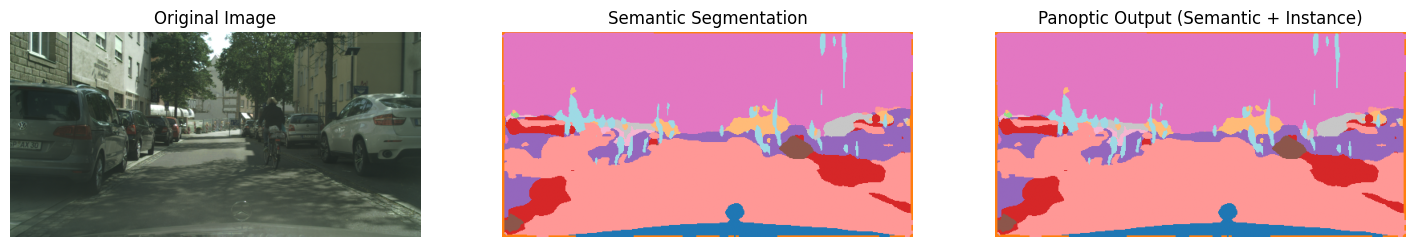

In [38]:
# ============================================================
# Inference on Single Image (Semantic + Panoptic)
# ============================================================
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# ----------------------------
# Settings
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_PATH = "/kaggle/working/panoptic_models/panoptic_epoch10.pth"  # عدّلي الاسم لو مختلف
IMG_PATH = "/kaggle/input/cityscapes/Cityspaces/images/train/ulm/ulm_000011_000019_leftImg8bit.png"

# ----------------------------
# Load Model
# ----------------------------
model = PanopticModel().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ----------------------------
# Preprocess Image
# ----------------------------
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")

    img_resized = transforms.functional.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img_tensor = transforms.functional.to_tensor(img_resized)
    img_tensor = transforms.functional.normalize(
        img_tensor, IMAGENET_MEAN, IMAGENET_STD
    )

    return img_tensor.unsqueeze(0), img

# ----------------------------
# Inference
# ----------------------------
@torch.no_grad()
def infer(img_path):
    x, original_img = preprocess_image(img_path)
    x = x.to(DEVICE)

    out = model(x)

    semantic = torch.argmax(out["sem"], dim=1)[0].cpu().numpy()
    panoptic = out["panoptic"][0].cpu().numpy()

    return original_img, semantic, panoptic

# ----------------------------
# Visualization
# ----------------------------
def visualize(original, semantic, panoptic):
    plt.figure(figsize=(18,5))

    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(semantic, cmap="tab20")
    plt.title("Semantic Segmentation")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(panoptic, cmap="tab20")
    plt.title("Panoptic Output (Semantic + Instance)")
    plt.axis("off")

    plt.show()

# ----------------------------
# Run Everything
# ----------------------------
original, semantic, panoptic = infer(IMG_PATH)
visualize(original, semantic, panoptic)
